In [5]:
%matplotlib inline
import isce
import os
import glob
import numpy as np
import shutil
from osgeo import gdal
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
#import uavsar_pytools

2023-11-14 13:22:18,353 - rasterio.session - DEBUG - Could not import boto3, continuing with reduced functionality.


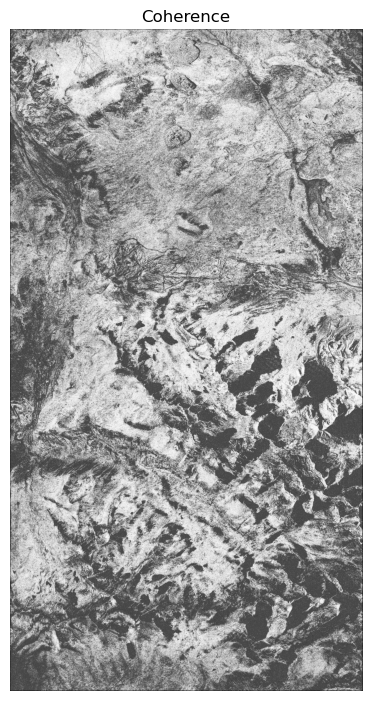

In [19]:
# plot amplitude and wrapped interferogram
# cor
w_int = '/Users/jtarrico/sierra_isce/igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.coh'
ds = gdal.Open(w_int, gdal.GA_ReadOnly)
coh = ds.GetRasterBand(1).ReadAsArray()
ds = None

fig = plt.figure(figsize=(10, 14))

ax = fig.add_subplot(1,2,1)
ax.imshow(coh, vmin = 0 , vmax = 1, cmap = 'gray')
ax.set_title("Coherence")
ax.set_axis_off()

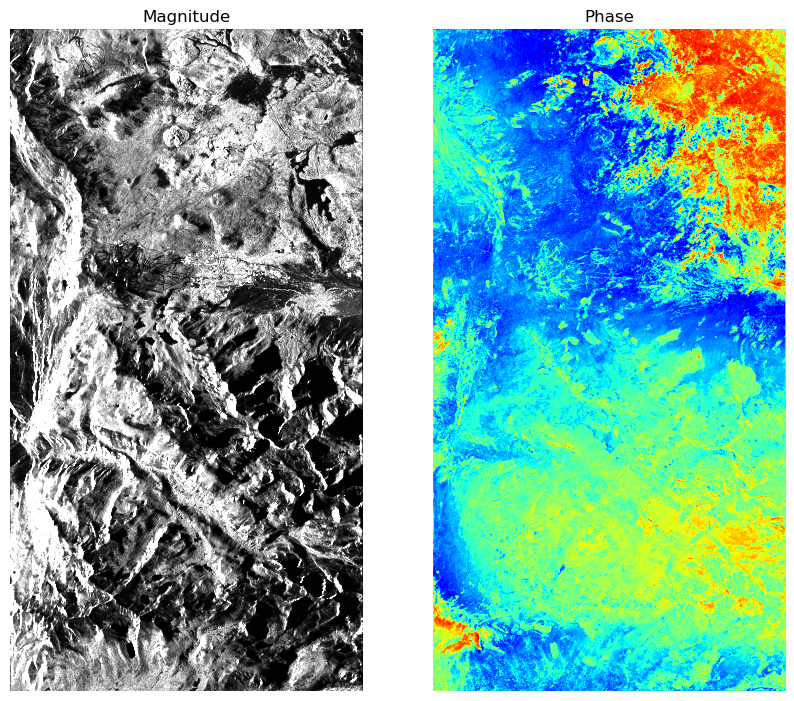

In [17]:
# plot amplitude and wrapped interferogram

w_int = '/Users/jtarrico/sierra_isce/igrams/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int'
ds = gdal.Open(w_int, gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

fig = plt.figure(figsize=(10, 14))

ax = fig.add_subplot(1,2,1)
ax.imshow(np.abs(igram), vmin = 0 , vmax = 10.0, cmap = 'gray')
ax.set_title("Magnitude")
ax.set_axis_off()

ax = fig.add_subplot(1,2,2)
ax.imshow(np.angle(igram), cmap = 'jet', vmax = 3.14, vmin = -3.14)
ax.set_title("Phase")
ax.set_axis_off()

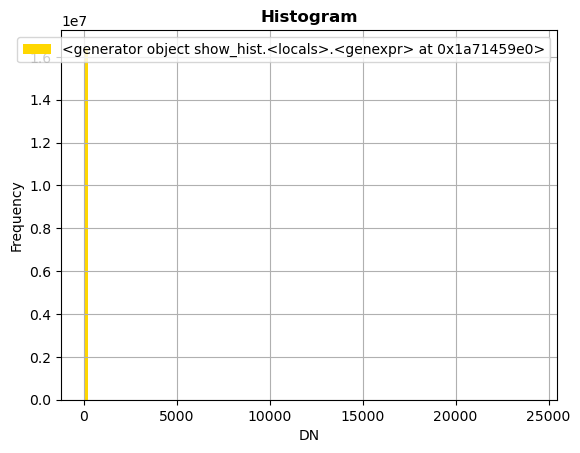

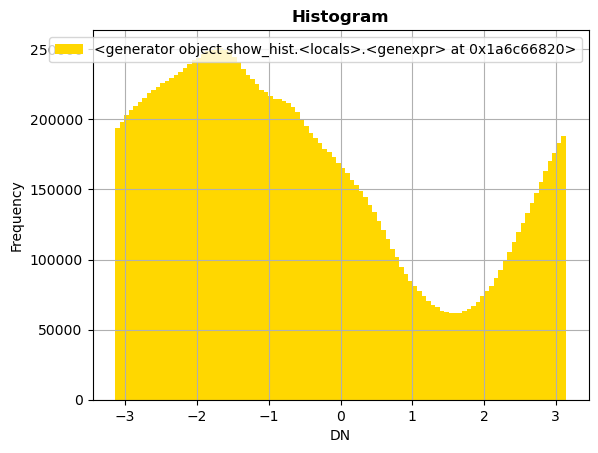

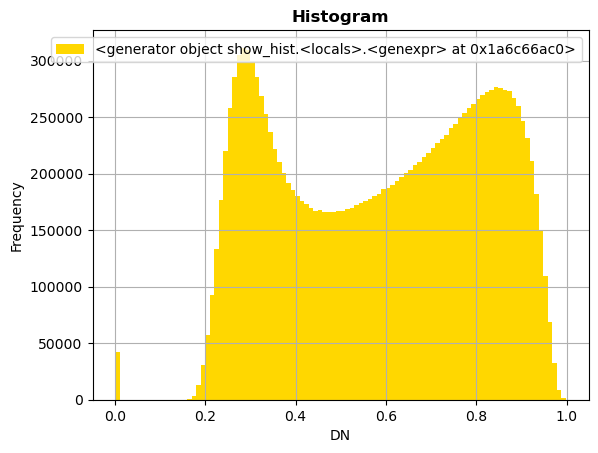

In [20]:
show_hist(np.abs(igram), bins = 100)
show_hist(np.angle(igram), bins = 100)
show_hist(coh, bins = 100)